# Assignment 4

#### Student ID: *Double click here to fill the Student ID*

#### Name: *Double click here to fill the name*

Firstly, install the following dependencies, you need to restart the kernel after the installation.

In [1]:
!pip install catboost -U -qq
!pip install xgboost -U -qq
!pip install lightgbm -U -qq
!pip install shap -qq
!pip install imodels -qq
!pip install bentoml==1.0.0.a7 -qq
!pip install pyngrok -qq
!pip install PyYAML -U -qq

     |████████████████████████████████| 76.6 MB 1.5 MB/s 
     |████████████████████████████████| 192.9 MB 59 kB/s 
     |████████████████████████████████| 2.0 MB 23.8 MB/s 
     |████████████████████████████████| 569 kB 19.4 MB/s 
     |████████████████████████████████| 192 kB 30.4 MB/s 
     |████████████████████████████████| 1.3 MB 42.7 MB/s 
     |████████████████████████████████| 602 kB 20.4 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 232 kB 49.6 MB/s 
     |████████████████████████████████| 57 kB 5.3 MB/s 
     |████████████████████████████████| 182 kB 49.6 MB/s 
     |████████████████████████████████| 135 kB 53.3 MB/s 
     |████████████████████████████████| 47 kB 3.6 MB/s 
     |████████████████████████████████| 64 kB 3.3 MB/s 
     |████████████████████████████████| 53 kB 2.5 MB/s 
     |████████████████████████████████| 1.1 MB 40.3 MB/s 
     |████████████████████████████████| 271 kB 50.8 MB/s 
     |██████████████████

If you are using colab or Kaggle notebook, try to setup the tunnel using the following commands.

In [1]:
from pyngrok import ngrok, conf
import getpass

In [2]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = getpass.getpass()

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········


In [3]:
# Setup a tunnel to the streamlit port 8050
public_url = ngrok.connect(8050)

## Q1: Analyze hospital readmission dataset with interpretable methods

Hospital readmission is an episode when a patient who had been discharged from a hospital is admitted again within a specified time interval. Generally, a higher readmission rate indicates the ineffectiveness of treatment during past hospitalizations. 

Therefore, the hospital wants your help identifying patients at the highest risk of being readmitted. Doctors will take care of the final decision about when to release each patient, but they hope you could build a model to highlight issues the doctors should consider when discharging a patient. The hospital has given you relevant patient medical information. The given dataset contains the following features:

* Your prediction target is `readmitted`
* Feature names like `number_inpatient` refers to the number of inpatient visits of the patient in the year preceding the encounter
* Features whose names with the word `diag` indicate the diagnostic code of the illness or illnesses the patient was admitted with. For example, `diag_1_428` means the doctor said their first illness diagnosis is number "428".  
* A feature name like `metformin_No` means the patient did not have the medicine `metformin.` If this feature had a value of False, then the patient did take the drug `metformin.`
* Features whose names begin with `medical_specialty` describe the specialty of the doctor who treats the patient. The values in these fields are all `True` or `False.`

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import warnings
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from matplotlib import pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imodels import FIGSClassifier, BayesianRuleListClassifier, OneRClassifier
from imodels.discretization import ExtraBasicDiscretizer
import bentoml
import re
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor


/usr/local/lib/python3.7/dist-packages/pip/_vendor/packaging/version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/pip/_vendor/packaging/version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/pip/_vendor/packaging/version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/pip/_vendor/packaging/version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/pip/_vendor/packaging/version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be remove

In [4]:
import pandas as pd
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from matplotlib import pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imodels import FIGSClassifier, BayesianRuleListClassifier, OneRClassifier
from imodels.discretization import ExtraBasicDiscretizer
import bentoml
import re
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor


X = pd.read_csv('hospital.csv')

X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


y = X.readmitted              
X.drop(['readmitted'], axis=1, inplace=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)

In the follwomg questions, whenever a randomness involves, set the random seed to 42.

(a) Firstly, fit an interpretable model and show doctors some evidence the model is doing something in line with their medical intuition. 

* Try to build an OneR decision rule model as a baseline and calculate the accuracy of the OneR model on the validation set. 
* Now, two patients (Their data are recorded in 21492 and 15100 rows in the original dataset) come in, and they would like to know why they get readmitted or do not get readmitted. Use the rule list generated from the OneR model to give them a reason.  

In [5]:
from matplotlib.pyplot import figure

In [6]:
# fit a oneR model
model = OneRClassifier()
model.fit(X_train, y=y_train, feature_names=X.columns) # stores into m.rules_
probs = model.predict_proba(X_val)
preds = model.predict(X_val)

# print the rule list
print("Learned interpretable model:\n", model)

Learned interpretable model:
 mean 0.455 (18750 pts)
if number_inpatient >= 1 then 0.602 (6406 pts)
mean 0.378 (12344 pts)
if number_inpatient >= 0 then 0.378 (12344 pts)



In [7]:
score = accuracy_score(preds, y_val)
print('Score: ' + str(score))

Score: 0.62048


In [8]:
patient1 = 21492
patient2 = 15100

In [9]:
X.iloc[patient1]['number_inpatient'], model.predict(X.iloc[patient1].values.reshape(1,-1)), y[patient1]

(0, array([0]), 0)

In [10]:
X.iloc[patient2]['number_inpatient'], model.predict(X.iloc[patient2].values.reshape(1,-1)), y[patient2]

(6, array([1]), 1)

Since the `number_inpatient` is higher than 0 for the second patient, it has a high chance of getting readmitted by the OneR model. The decision results are also consistent with the true target.

(b) The doctor is glad that you convinced the patients, but he is still worried about the model performance of OneR you just built. 

* Try to build a more complicated classifier using `LightGBM`, train the model that gives a maximum of 5,000 trees and will stop after 100 consecutive rounds fail to find any improvement. 
* Then report the accuracy of the validation set. Finally, plot the feature importance (Use `gain` as the type of importance instead of `split`) of the top ten important features.

Hint: The [early stop callback](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.early_stopping.html) and [feature_importance](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Booster.html#lightgbm.Booster.feature_importance) attributes may be useful.

In [11]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', random_state=42, n_estimators=5000)
eval_set = [(X_val, y_val)]

clf.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=100)

[1]	valid_0's binary_logloss: 0.682716
[2]	valid_0's binary_logloss: 0.676808
[3]	valid_0's binary_logloss: 0.671599
[4]	valid_0's binary_logloss: 0.66761
[5]	valid_0's binary_logloss: 0.664167
[6]	valid_0's binary_logloss: 0.661215
[7]	valid_0's binary_logloss: 0.658624
[8]	valid_0's binary_logloss: 0.656567
[9]	valid_0's binary_logloss: 0.654813
[10]	valid_0's binary_logloss: 0.653449
[11]	valid_0's binary_logloss: 0.652047
[12]	valid_0's binary_logloss: 0.650875
[13]	valid_0's binary_logloss: 0.649965
[14]	valid_0's binary_logloss: 0.649368
[15]	valid_0's binary_logloss: 0.648472
[16]	valid_0's binary_logloss: 0.647924
[17]	valid_0's binary_logloss: 0.647352
[18]	valid_0's binary_logloss: 0.647009
[19]	valid_0's binary_logloss: 0.646466
[20]	valid_0's binary_logloss: 0.646019
[21]	valid_0's binary_logloss: 0.645296
[22]	valid_0's binary_logloss: 0.64498
[23]	valid_0's binary_logloss: 0.644455
[24]	valid_0's binary_logloss: 0.644132
[25]	valid_0's binary_logloss: 0.643954
[26]	valid_

LGBMClassifier(n_estimators=5000, random_state=42)

In [12]:
y_pred = clf.predict(X_val)
score = accuracy_score(y_pred, y_val)
print('Score: ' + str(score))

Score: 0.63376


In [13]:
prediction_importance = clf.booster_.feature_importance(importance_type='gain')

In [14]:
feature_imp = pd.DataFrame(sorted(zip(clf.booster_.feature_importance(importance_type='gain'),X_val.columns)), columns=['Value','Feature'])
feature_imp

,Value,Feature
0,0.000000,acetohexamide_No
1,0.000000,chlorpropamide_No
2,0.000000,citoglipton_No
3,0.000000,examide_No
4,0.000000,glimepiridepioglitazone_No
...,...,...
59,703.445474,number_emergency
60,1173.226842,num_lab_procedures
61,1210.141407,num_medications
62,1436.173952,number_diagnoses


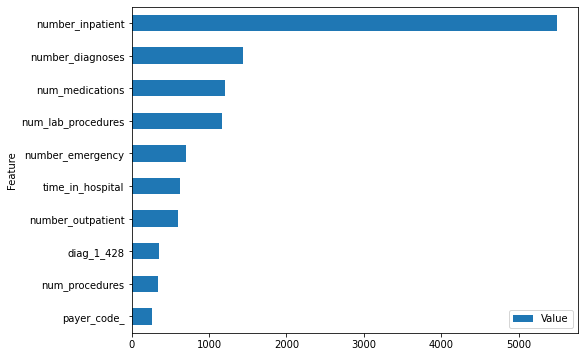

In [15]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [8, 6]
prediction_i = feature_imp.iloc[-10:]
prediction_i.plot.barh(x='Feature', y='Value')

(c) It appears `number_inpatient` is a critical feature, and the doctors would like to know more about that. 

* Create a partial dependence plot and an individual conditional expectation plot for them that shows how `num_inpatient` affects the model's predictions. (You should use the validation set to generate the plot)
* In addition, also create the partial dependence plot and the individual conditional expectation plot for the `time_in_hospital` so that they can tell from these plots whether the effect of the `number_inpatient` on the target is big or small. 
* Comment on your results.

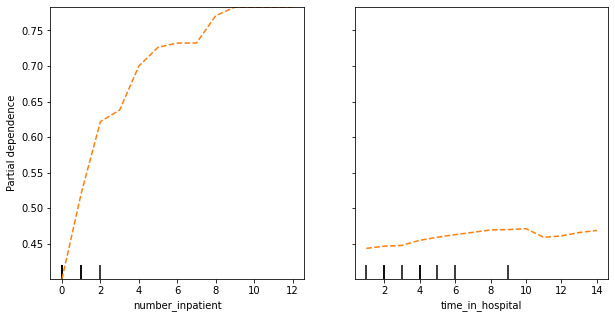

In [16]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]
features = ["number_inpatient", "time_in_hospital"]
display = PartialDependenceDisplay.from_estimator(
    clf,
    X_val,
    features,
    grid_resolution=20,
    random_state=0,
    pd_line_kw={"color": "tab:orange", "linestyle": "--"}
)

display.figure_.subplots_adjust(hspace=0.3)

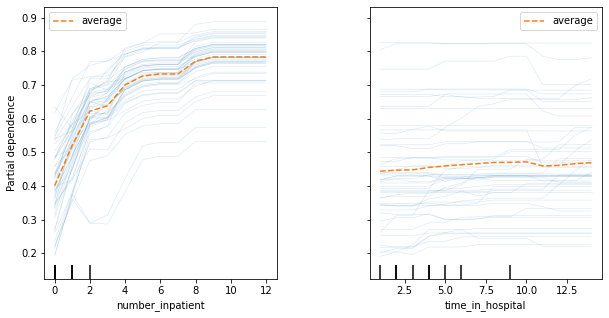

In [17]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]
features = ["number_inpatient", "time_in_hospital"]
display = PartialDependenceDisplay.from_estimator(
    clf,
    X_val,
    features,
    kind="both",
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

The PDP and ICE plots show that `number_inpatient` is highly correlated with the target and `time_in_hospital` has relatively low relevance to the target.

(d) Now, the doctors are looking for the local explanations of your model. 
* Try to create a force plot (for the previous two patients) and a summary plot of Shapley values.  (You should use the validation set to generate the plot)
* Use the force plot to give the previous two patients (Their data are recorded in 21492 and 15100 rows in the original dataset) why they were readmitted or not.
* Does the summary plot consistent with the feature importance plot?

In [18]:
import shap  # package used to calculate Shap values

explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X)

/usr/local/lib/python3.7/dist-packages/numba/core/types/__init__.py:108: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  long_ = _make_signed(np.long)
/usr/local/lib/python3.7/dist-packages/numba/core/types/__init__.py:109: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need t

In [19]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][patient1,:], X.iloc[patient1])

In [20]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][patient2,:], X.iloc[patient2])

The force plot also demonstrates that the `number_inpatient` is an important feature; therefore, for patient 1, it will lower the probability of being readmitted, while for patient 2, it will increase the probability of being readmitted to due to the different value present in this feature for these two patients. 

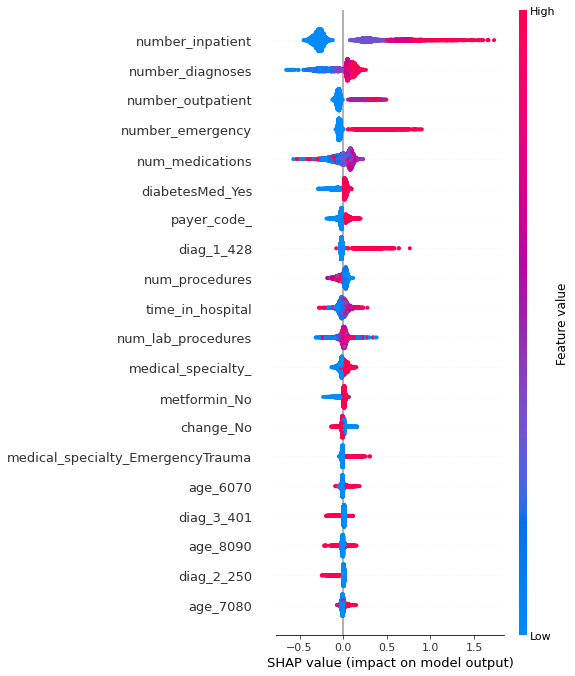

In [20]:
shap.summary_plot(shap_values[1], X_val)

For the summary plot, the overall trend is consistent with the feature importance plot, except some features change their order.

(e) Now the doctors are convinced you have the right data, and the model overview looked reasonable. It's time to turn this into a finished product they can use. 
* Try to use `BentoML` to save your LightGBM model, then reload it. 
* Use the reloaded model to make inferences on the previous two patients. Show that the inference results are the same as the original model for these two patients.

Hint: You may refer to https://docs.bentoml.org/en/latest/frameworks/lightgbm.html and our lab for more information.

In [21]:
bentoml.__version__

'1.0.0a7'

In [22]:
tag = bentoml.lightgbm.save("my_lightgbm_model", clf)

06/16/2022 08:24:32 AM INFO     [cli] Successfully saved                                     
                                Model(tag="my_lightgbm_model:x7r3iqxnjwxiaasc", path="/root/b
                                entoml/models/my_lightgbm_model/x7r3iqxnjwxiaasc/")

In [23]:
!bentoml models list

 Tag              Module           Size        Creation Time    Path            
 my_lightgbm_mo…  bentoml.lightg…  156.71 KiB  2022-06-16       ~/bentoml/mode… 
                                               08:24:32                         


In [40]:
test_runner = bentoml.lightgbm.load_runner("my_lightgbm_model")
test_runner.run(X.iloc[patient1].to_numpy()), clf.predict(X.iloc[patient1].values.reshape(1,-1)), y[patient1]

(array(0), array([0]), 0)

In [41]:
test_runner.run(X.iloc[patient2].to_numpy()), clf.predict(X.iloc[patient2].values.reshape(1,-1)), y[patient2]

(array(1), array([1]), 1)

(f) Deploy your model as a REST API server using `BentoML.` In addition, test your server by sending a request that contains the data of the previous two patients. Show that the responses from the server are the same as the predictions of the original model for these two patients.

Hint: You should first transform the boolean value to an integer (True to 1 and False to 0) and transform the integer to a string before sending the request to your server.

In [28]:
%%writefile service.py
import numpy as np
import bentoml
from bentoml.io import NumpyNdarray

# Load the runner for the latest lgbm model we just saved
test_runner = bentoml.lightgbm.load_runner("my_lightgbm_model")

# Multiple runners may be specified if needed in the runners array
# When packaged as a bento, the runners here will included
lgbm = bentoml.Service("classifier", runners=[test_runner])

# Create API function with pre- and post- processing logic with your new "lgbm" annotation
@lgbm.api(input=NumpyNdarray(), output=NumpyNdarray())
def classify(input_series: np.ndarray) -> np.ndarray:
    # Define pre-processing logic
    result = test_runner.run(input_series)
    # Define post-processing logic
    return result

Writing service.py


In [33]:
!nohup bentoml serve ./service.py:lgbm --reload --port 8050 &

nohup: appending output to 'nohup.out'


In [30]:
patient1_query = X.iloc[patient1].to_numpy()+0

In [31]:
import requests

In [34]:
requests.post(
    "http://127.0.0.1:8050/classify",
    headers={"content-type": "application/json"},
    data=str(patient1_query.tolist())).text

'0'

In [38]:
patient2_query = X.iloc[patient2].to_numpy()+0

In [39]:
requests.post(
    "http://127.0.0.1:8050/classify",
    headers={"content-type": "application/json"},
    data=str(patient2_query.tolist())).text

'1'

In [43]:
!pgrep bentoml

637


In [44]:
!kill 637

## Q2 Revisit the Ames housing dataset with ensemble learning

Firstly, use the following code snippet to set up the dataset. Note the CSV file can be downloaded from our course website.

In [45]:
# Read the data
X = pd.read_csv("ames.csv")
#  Separate target from predictors
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality 
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In the following questions, when you use methods
that are inherently random, make sure to use, set the random seed to 42.

(a) You'll build and train a gradient boosting in this step.

* Use one-hot encoding for the categorical variable.
* Training an XGBoost regression model.   **Leave all other parameters as default.**
* Then, fit the model to the training data and calculate the mean absolute error (MAE) corresponding to the predictions for the validation set.

Hint: Since we are working with both training and validation sets, try to apply the same transform when you encode the variables. You may find [ColumnTransformer](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html) and the `handle_unknown` option in the encoder useful.

In [47]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [48]:
transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), low_cardinality_cols),
    remainder='passthrough')

In [49]:
transformed = transformer.fit_transform(X_train)
transformed_df = pd.DataFrame(
    transformed.todense(), 
    columns=transformer.get_feature_names()
)

In [50]:
transformed_df

,onehotencoder__x0_A_agr,onehotencoder__x0_C_all,onehotencoder__x0_Floating_Village_Residential,onehotencoder__x0_I_all,onehotencoder__x0_Residential_High_Density,onehotencoder__x0_Residential_Low_Density,onehotencoder__x0_Residential_Medium_Density,onehotencoder__x1_Grvl,onehotencoder__x1_Pave,onehotencoder__x2_Gravel,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,Threeseasonporch,ScreenPorch,PoolArea,MiscVal,MoSold,YearSold
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,479.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2009.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,538.0,486.0,0.0,0.0,0.0,225.0,0.0,0.0,6.0,2009.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,462.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2007.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,420.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2009.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,148.0,0.0,0.0,0.0,0.0,10.0,2009.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2339,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,828.0,144.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2007.0
2340,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,403.0,100.0,35.0,0.0,0.0,0.0,0.0,0.0,4.0,2008.0
2341,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,673.0,216.0,56.0,0.0,0.0,0.0,0.0,0.0,5.0,2008.0
2342,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,225.0,0.0,0.0,236.0,0.0,0.0,0.0,0.0,6.0,2008.0


In [51]:
transformed = transformer.transform(X_valid)
transformed_df2 = pd.DataFrame(
    transformed.todense(), 
    columns=transformer.get_feature_names()
)

In [52]:
from xgboost import XGBRegressor

# Define the model
my_model_1 = XGBRegressor(random_state=42)

# Fit the model
my_model_1.fit(transformed_df, y_train)
predictions_1 = my_model_1.predict(transformed_df2)
# Calculate MAE
mae_1 = mean_absolute_error(predictions_1, y_valid)
print("Mean Absolute Error:" , mae_1)

Mean Absolute Error: 16820.732781836603


(b) A simple technique for improving the gradient boosting model is to use a lower learning rate with larger iterations. Try to build another `XGBRegressor` with a learning rate set to 0.05 and the number of estimators set to 1000 and calculate the MAE on the validation set.

In [53]:
my_model_2 = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
# Fit the model
my_model_2.fit(transformed_df, y_train)
predictions_2 = my_model_2.predict(transformed_df2)
# Calculate MAE
mae_2 = mean_absolute_error(predictions_2, y_valid)
print("Mean Absolute Error:" , mae_2)

Mean Absolute Error: 15460.122896890998


In [54]:
from sklearn.pipeline import Pipeline

In [56]:
pipe = Pipeline([('onehot', transformer), ('xgb', my_model_2)])

(c) Now train an LGBMRegressor and a CatBoostRegressor with default parameters on the original training data (do not use one-hot encoding before feeding into the models this time; instead, let the models deal with it). Calculate the MAE on the validation set for these two models.

Hint: You may refer to our lab to see how to deal with categorical variables inside these two frameworks.

In [58]:
for col in low_cardinality_cols:
  X_train[col] = X_train[col].astype('category')
  X_valid[col] = X_valid[col].astype('category')

In [59]:
lgbr = lgb.LGBMRegressor(random_state=42)
lgbr.fit(X_train, y_train)

lpredictions_1 = lgbr.predict(X_valid)
# Calculate MAE
lmae_1 = mean_absolute_error(lpredictions_1, y_valid)
print("Mean Absolute Error:" , lmae_1)

Mean Absolute Error: 16723.16377409791


In [60]:
catbr = CatBoostRegressor(random_state=42, logging_level = 'Silent', cat_features=low_cardinality_cols)
catbr.fit(X_train, y_train)

In [61]:
cpredictions_1 = catbr.predict(X_valid)
# Calculate MAE
cmae_1 = mean_absolute_error(cpredictions_1, y_valid)
print("Mean Absolute Error:" , cmae_1)

Mean Absolute Error: 14698.984166127013


(d) Build an ensemble model using the hard voting regressor for the `XGBRegressor` in (b), the `LGBMRegressor`, and the `CatBoostRegressor` in (c). Fit the ensemble model on the original training dataset and calculate the MAE on the validation set. In addition, also build a stacking regressor for these three models, fit on the original dataset and calculate the MAE on the validation set. Finally, comment on your results.

Hint: You may find [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) useful when you combine three models with different preprocessing steps.

In [62]:
from sklearn.ensemble import VotingRegressor

In [63]:
named_estimators = [
    ("xgboost", pipe),
    ("lgbm", lgbr),
    ("catboost", catbr),
]

In [64]:
voting_res = VotingRegressor(named_estimators)

In [65]:
voting_res.fit(X_train, y_train)

fpredictions = voting_res.predict(X_valid)
# Calculate MAE
fmae = mean_absolute_error(fpredictions, y_valid)
print("Mean Absolute Error:" , fmae)

Mean Absolute Error: 14975.075240023625


In [72]:
stack_clf = StackingRegressor(named_estimators, cv=5)
stack_clf.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('xgboost',
                               Pipeline(steps=[('onehot',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('onehotencoder',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 ['MSZoning',
                                                                                  'Street',
                                                                                  'Alley',
                                                                                  'LotShape',
                                                                                  'LandContour',
                                                                                  'Utilities',
   

In [73]:
fpredictions2 = stack_clf.predict(X_valid)

# Calculate MAE
fmae2 = mean_absolute_error(fpredictions2, y_valid)
print("Mean Absolute Error:" , fmae2)

Mean Absolute Error: 14777.206109288447


The stacking performs better than voting, showing that tacking the average may not be the best strategy for the ensemble in the regression setting.